In [59]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd

import matplotlib.pyplot as plt
import pickle

import bamboolib

from fredapi import Fred
fred = Fred(api_key='98d7e668ce51c2997660ab73367c689a')

from tqdm import tqdm

import plotly
import plotly.offline
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import HTML
from IPython.core.display import display, HTML
import copy

# Plotly settings
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

# 1. Load datasets

In [60]:
df_filename = '../../data/processed/asset_prices_M.pkl'
bf_dataset_filename = '../../data/processed/base_assets_M.pkl'
df_W_filename = '../../data/processed/asset_prices_W.pkl'
bf_W_dataset_filename = '../../data/processed/base_assets_W.pkl'
kf_asof_dataset_filename = '../../data/processed/kf_asof_dataset_M.pkl'
kf_asof_W_dataset_filename = '../../data/processed/kf_asof_dataset_W.pkl'

In [61]:
_freq = 'M'

In [62]:
if _freq == 'M':
    one_yr = 12
    two_yrs = 24
elif _freq == 'W':
    one_yr = 52
    two_yrs = 104

In [63]:
if _freq == 'M':
    df = pd.read_pickle(df_filename)
    bf = pd.read_pickle(bf_dataset_filename)
    with open(kf_asof_dataset_filename, 'rb') as f:
        kf_asof = pickle.load(f)
elif _freq == 'W':
    df = pd.read_pickle(df_W_filename)
    bf = pd.read_pickle(bf_W_dataset_filename)
    with open(kf_asof_W_dataset_filename, 'rb') as f:
        kf_asof = pickle.load(f)


# 3. Estimate recession probabilities

### Comparisons

In [64]:
lei_idx = [
    ('Labor', 'Average weekly hours, manufacturing'),
    ('Labor','Average weekly initial claims for unemployment insurance'),
    ('Labor', 'Nonfarm payrolls'),
    ('Manufacturing', 'ISM PMI'),
    ('Manufacturing', 'New orders (other goods)'),
    ('>Manufacturing', 'Industrial production'),
    ('Housing', 'Building permits, new private housing units'),
    ('Financial', 'Stock prices'),
    ('Financial', 'Leading Credit Index™'),
    ('Financial', 'Interest rate spread, 10-year Treasury bonds less federal funds'),
    ('Consumer survey','Consumer confidence'),
]
lei_idx = pd.MultiIndex.from_tuples(lei_idx, names=['Markets', 'Names'])
comp = {
    'Conf. Board LEI': ['O', 'O', '', '', 'OOO', '', 'O','O',  'O', 'O', 'O'],
    'OECD CLI USA': ['O', '', '', 'O', 'O', 'O', 'O', 'O', '', 'O', 'O'],
    'KKT Index': ['', '', 'O', '', '', 'O', '', 'O', '', 'O', '']
}

In [65]:
pd.DataFrame(data=comp, index=lei_idx)

Conf. Board LEI  \
Markets         Names                                                                
Labor           Average weekly hours, manufacturing                              O   
                Average weekly initial claims for unemployment ...               O   
                Nonfarm payrolls                                                     
Manufacturing   ISM PMI                                                              
                New orders (other goods)                                       OOO   
>Manufacturing  Industrial production                                                
Housing         Building permits, new private housing units                      O   
Financial       Stock prices                                                     O   
                Leading Credit Index™                                            O   
                Interest rate spread, 10-year Treasury bonds le...               O   
Consumer survey Consumer confidence                                              O   

                                                                   OECD CLI USA  \
Markets         Names                                                             
Labor           Average weekly hours, manufacturing                           O   
                Average weekly initial claims for unemployment ...                
                Nonfarm payrolls                                                  
Manufacturing   ISM PMI                                                       O   
                New orders (other goods)                                      O   
>Manufacturing  Industrial production                                         O   
Housing         Building permits, new private housing units                   O   
Financial       Stock prices                                                  O   
                Leading Credit Index™                                             
                Interest rate spread, 10-year Treasury bonds le...            O   
Consumer survey Consumer confidence                                           O   

                                                                   KKT Index  
Markets         Names                                                         
Labor           Average weekly hours, manufacturing                           
                Average weekly initial claims for unemployment ...            
                Nonfarm payrolls                                           O  
Manufacturing   ISM PMI                                                       
                New orders (other goods)                                      
>Manufacturing  Industrial production                                      O  
Housing         Building permits, new private housing units                   
Financial       Stock prices                                               O  
                Leading Credit Index™                                         
                Interest rate spread, 10-year Treasury bonds le...         O  
Consumer survey Consumer confidence

## (1) Make two sub-samples
- Recession periods
- Robust growth periods

- `rec_months`: 1 if a month belongs to a recession period if ; 0 if expansion.
- `rec_dt`: a Series of months identified as recessions by the NBER.

In [66]:
kf_latest = kf_asof[max(list(kf_asof.keys()))]
earlist_year = kf_latest.index[0].year
rec_months = fred.get_series_latest_release('USREC')
rec_months = rec_months[rec_months.index.year >= earlist_year]

rec_months.index = pd.to_datetime(rec_months.index).to_period('M')
if _freq == 'M':
    rec_dt = pd.Series(rec_months[rec_months==1].index.to_timestamp(), name='rec_date')
elif _freq == 'W':
    rec_months = rec_months.resample('W-FRI', kind='period').ffill()
    rec_dt = pd.Series(rec_months[rec_months==1].index.to_timestamp(freq='W-FRI', how='E'), name='rec_date')

- `rg_threshold` is the `IP` value at the `rg_percentile` relative to the prior `rg_lookback` months (or weeks)

In [67]:
rg_percentile = 75
rg_lookback = 120 if _freq == 'M' else 520
rg_threshold = [np.percentile(kf_latest.IP[n:n+rg_lookback], rg_percentile) for n in range(0,kf_latest.index.shape[0]-rg_lookback)]
rg_threshold = pd.Series(data=rg_threshold, index=kf_latest[-(kf_latest.index.shape[0]-rg_lookback):].index)

- `rg_dt` is robust growth periods identified using `IP` ranked above at `rg_percentile` relative to the prior `rg_lookback` periods.

In [68]:
rg_dt = pd.Series(kf_latest[rg_lookback:].index[kf_latest.IP[rg_lookback:] > rg_threshold].to_timestamp(), name='rg_date')

- Load the OECD CLI USA index for comparison.

In [69]:
cli_usa = fred.get_series_latest_release('USALOLITOAASTSAM')
cli_usa.index = cli_usa.index + MonthEnd(0)

if _freq == 'M':
    cli_usa.index = pd.to_datetime(cli_usa.index).to_period('M')
elif _freq == 'W':
    cli_usa.index = pd.to_datetime(cli_usa.index).to_period('W-FRI')

cli_usa.name = 'OECD_CLI_USA'
cli = pd.DataFrame(index=kf_latest.index[rg_lookback:])
cli = cli.merge(cli_usa, left_index=True, right_index=True, how='left')
cli = cli.apply(lambda col: col.loc[col.first_valid_index():col.last_valid_index()].fillna(method='ffill'))
cli.index = cli.index.to_timestamp(how='E')

In [70]:
from dateutil.relativedelta import *

def get_start_end_dates(dt, _freq):
    '''
    Returns a pair of two lists; start and end. A consecutive period starts from start[n] and ends on end[n].
    
    Arguments:
    dt : Series
        Its values are dates and type is Timestamp 
    
    _freq : string
        either 'M' for monthly or 'W' for weekly
        
    month_end : Boolean
        Change dates in "end" list to %Y-%d-LastDay from %Y-%d-01.
        
    Returns:
    The first list contains start dates and the second list contains end dates.
    '''
    
    if dt.empty:
        return [], []
    
    n = 0
    start = []
    end = []
    start.append(dt.iloc[0])
    prev = dt.iloc[0]
    
    unit_period = relativedelta(months=1) if _freq == 'M' else relativedelta(weeks=1)
    done_flag = False
    
    for d in dt.iloc[1:]:
        if done_flag:
            # As done_flag is marked, we add a start date into the `start` list.
            start.append(prev)
            done_flag = False

        if d != (prev + unit_period):
            # if dates are not consecutive, than it means it's an end point.
            if _freq == 'M':
                end.append(prev + MonthEnd(0))
            elif _freq == 'W':
                end.append(prev)
            
            # Mark this flag as true so that we can append a start date.
            done_flag = True
        
        prev = d
        
    end.append(d)

    return start, end

In [71]:
rg_starts, rg_ends = get_start_end_dates(rg_dt[rg_dt>='1956'], _freq)
rec_starts, rec_ends = get_start_end_dates(rec_dt[rec_dt>='1956'], _freq)

In [72]:
def multiShades(fig, x0, x1):
    """ Adds shaded areas for specified dates in a plotly plot.
        The lines of the areas are set to transparent using rgba(0,0,0,0)
    """

    # get dict from tuple made by vspan()
    xElem = fig['layout']['shapes'][0]

    # container (list) for dicts / shapes
    shp_lst=[]

    # make dicts according to x0 and X1
    # and edit elements of those dicts
    for i in range(0,len(x0)):
        shp_lst.append(copy.deepcopy(xElem))
        shp_lst[i]['x0'] = x0[i]
        shp_lst[i]['x1'] = x1[i]
        shp_lst[i]['line']['color'] = 'rgba(0,0,0,0)'

    # replace shape in fig with multiple new shapes
    fig['layout']['shapes']= tuple(shp_lst)
    return(fig)

In [73]:
rec_fig = cli.iplot(
    asFigure=True,
    kind='scatter',
    xTitle='Dates',
    yTitle='Returns',
    title='OECD CLI USA with recessions in gray',
    colors='blue',
    vspan={
        'x0': rec_starts,
        'x1': rec_ends,
        'color': 'gray',
        'fill': True,
        'opacity': .4
    }
)

In [74]:
rec_starts = [dt.strftime('%Y-%m-%d') for dt in rec_starts]
rec_ends = [dt.strftime('%Y-%m-%d') for dt in rec_ends]

In [75]:
rec_fig = multiShades(rec_fig, x0=rec_starts, x1=rec_ends)
iplot(rec_fig)

#### Finally we have access to the sub-samples via `rec_dt` and `rg_dt`.
Now `rec_dt` and `rg_dt` have recession periods and robust growth periods, respectively.
- kf_latest.loc[rg_dt.index] returns a dataframe for robust growth periods.

In [76]:
rec_dt = rec_dt[rec_dt.dt.year >= 1926].reset_index(drop = True)

if _freq == 'M':
    all_dt = pd.Series(kf_latest[kf_latest.index.year >= 1926].index.to_timestamp().strftime('%Y-%m'), name='all_dates')
    rec_dt.index = pd.PeriodIndex(rec_dt, freq='M')
    rg_dt.index = pd.PeriodIndex(rg_dt, freq='M')
elif _freq == 'W':
    all_dt = pd.Series(kf_latest[kf_latest.index.year >= 1926].index.to_timestamp(freq='W-FRI', how='E').strftime('%Y-%m-%d'), name='all_dates')
    rec_dt.index = pd.PeriodIndex(rec_dt, freq='W-FRI')
    rg_dt.index = pd.PeriodIndex(rg_dt, freq='W-FRI')
    
all_dt.index = pd.PeriodIndex(kf_latest[kf_latest.index.year >= 1926].index, freq='W-FRI')

## (2) Calculate recession probabilities and robust growth probabilities
- Step 1: Get the Mahalanobis distance for each month's observations from each of the two sub-samples, calling it `d_rec_emp` and `d_rg_emp`
  - A suffix `_emp` is used to emphasize a covariance matrix is an empirical covariance matrix using *past* episodes of recession or robust growth.
- Step 2: Convert each distance into likelihood using the multivariate normal PDF.
- Step 3: Divide a recession distance by the sum of the recession distance and robust growth distance at the same point in time, and interpret the result as a probability of recession. Do the same for a growth distance.

In [77]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
from scipy.stats import multivariate_normal

- `X_rec` is the dataset for recession periods
- `X_rg` is the dataset for robust growth periods.

- For pre-1956, we use data that are not available at the time; rather, we use the latest information as of today.
- For the rest of dates, we only use data available at each point in time (we use revisions as well if any).

In [78]:
d_rec = {}
d_rg = {}

d_rec_emp = {}
d_rg_emp = {}

rec_prob = {}
rg_prob = {}

rec_prob_emp = {}
rg_prob_emp = {}

for dt in tqdm(all_dt['1956':]):
    X = kf_asof[dt]   # dataset X available as of `dt`
    X_rec = X.loc[rec_dt[:dt].iloc[:-1].index]  # data during recession periods AND we exclude data on `dt` (by '.iloc[:-1]')
    X_rg = X.loc[rg_dt[:dt].iloc[:-1].index]  # data during robust growth periods AND we exclude data on `dt` (by '.iloc[:-1]')
    obs = X.iloc[-1]  # The latest observation for which the Mahalanobis distance will be calcaulted.
    
    # fit a Minimum Covariance Determinant (MCD) robust estimator to data
    rec_robust_cov = MinCovDet().fit(X_rec)
    rg_robust_cov = MinCovDet().fit(X_rg)
    
    rec_emp_cov = EmpiricalCovariance().fit(X_rec)
    rg_emp_cov = EmpiricalCovariance().fit(X_rg)
    
    # mahalanobis() returns a list, but we only have one observation so that we just take [0].
    d_rec[dt] = rec_robust_cov.mahalanobis(obs.values.reshape(1,-1))[0]
    d_rg[dt] = rg_robust_cov.mahalanobis(obs.values.reshape(1,-1))[0]
    
    d_rec_emp[dt] = rec_emp_cov.mahalanobis(obs.values.reshape(1,-1))[0]
    d_rg_emp[dt] = rg_emp_cov.mahalanobis(obs.values.reshape(1,-1))[0]
    
    # Convert the Mahalanobis distances into likelihood.
    denom_rec = 1/np.sqrt((2*np.pi)*np.linalg.det(rec_robust_cov.covariance_))
    denom_rg = 1/np.sqrt((2*np.pi)*np.linalg.det(rg_robust_cov.covariance_))
    
    # This is likelihood.
    rec_llh = np.exp(-0.5*d_rec[dt])*denom_rec
    rg_llh = np.exp(-0.5*d_rg[dt])*denom_rg
    
    # We divide a likelihood by the sum of the two likelihoods and interprete it as a probability.
    rec_prob[dt] = rec_llh / (rec_llh + rg_llh)
    rg_prob[dt] = rg_llh / (rec_llh + rg_llh)
    
    denom_rec_emp = 1/np.sqrt((2*np.pi)*np.linalg.det(rec_emp_cov.covariance_))
    denom_rg_emp = 1/np.sqrt((2*np.pi)*np.linalg.det(rg_emp_cov.covariance_))
    rec_llh = np.exp(-0.5*d_rec_emp[dt])*denom_rec_emp
    rg_llh = np.exp(-0.5*d_rg_emp[dt])*denom_rg_emp  
    rec_prob_emp[dt] = rec_llh / (rec_llh + rg_llh)
    rg_prob_emp[dt] = rg_llh / (rec_llh + rg_llh)
    

100%|████████████████████████████████████████████████████████████████████████████████| 774/774 [01:14<00:00, 10.43it/s]


Now we have the Mahalanobis distances as follows:
- `d_rec`: from each observation to a recession periods distribution.
- `d_rg`: from each observation to a robust growth periods distibution.

In [79]:
rec_prob_emp = pd.DataFrame.from_dict(rec_prob_emp, orient='index', columns=['recession_prob'])
rg_prob_emp = pd.DataFrame.from_dict(rg_prob_emp, orient='index', columns=['growth_prob'])

if _freq == 'M':
    rec_prob_emp.set_index(pd.PeriodIndex(rec_prob_emp.index, freq='M'), inplace=True)
    rg_prob_emp.set_index(pd.PeriodIndex(rg_prob_emp.index, freq='M'), inplace=True)
elif _freq == 'W':
    rec_prob_emp.set_index(pd.PeriodIndex(rec_prob_emp.index, freq='W-FRI'), inplace=True)
    rg_prob_emp.set_index(pd.PeriodIndex(rg_prob_emp.index, freq='W-FRI'), inplace=True)

### Now we have the `KKT` index that shows recession probabilities in `prob_emp`
- `recession_prob`, `growth_prob`

In [80]:
prob_emp = pd.merge(rec_prob_emp, rg_prob_emp, how='inner', left_index=True, right_index=True)
prob_emp.set_index(prob_emp.index.to_timestamp(freq='W-FRI', how='end'), drop=True, inplace=True)
prob_emp = pd.merge(prob_emp, cli, how='left', left_index=True, right_index=True)
prob_emp['rec_std'] = ((prob_emp.recession_prob - prob_emp.recession_prob.shift(1).rolling(window=one_yr).mean()) / prob_emp.recession_prob.shift(1).rolling(window=one_yr).std())
prob_emp['recession_prob_rising'] = prob_emp[prob_emp.rec_std>=1].recession_prob

In [81]:
prob_emp.set_index(prob_emp.index.normalize(), drop=True, inplace=True)

In [82]:
rec_emp_fig = prob_emp[['recession_prob', 'recession_prob_rising']].iplot(
    asFigure=True,
    kind='scatter',
    xTitle='Dates',
    yTitle='OECD CLI USA (reversed)',
    title='Recession probabilities (Empirical)',
#     secondary_y=['recession_prob', 'recession_prob_rising'],
#     secondary_y_title='Recession probabilities',
    colors=['orange', 'red'],
    width=2,
    vspan={
        'x0': rec_starts,
        'x1': rec_ends,
        'color': 'gray',
        'fill': True,
        'opacity': .3
    })

In [83]:
# rec_emp_fig.layout.yaxis = dict(autorange='reversed')

In [84]:
rec_emp_fig = multiShades(rec_emp_fig, x0=rec_starts, x1=rec_ends)
iplot(rec_emp_fig)

We are interested when this recession probabilities rise. So, we set a threshold as one standard deviation relative to prior one year as indicated in red lines.

### (3) Analysis of predictive powers

In [85]:
import datetime

In [86]:
r_pr = prob_emp.recession_prob_rising

In [87]:
diff = {}
period_dist = {}
prob_table = {}
month_dist = [0, 1, 3, 6, 12, 18]
for threshold in [0.5, 0.6, 0.7, 0.8, 0.9]:
#     pred_dt = r_pr[np.logical_and(r_pr>=threshold, r_pr<threshold+0.1)]
    pred_dt = r_pr[r_pr>=threshold]
    
    # `diff[threshold]` contains period-distances in months or weeks from the date satisfying the `threshold`.
    diff[threshold] = [np.around(((rec_dt + MonthEnd(0)) - dt)/np.timedelta64(1, 'M')).values.astype(int) for dt in pred_dt.index]
    period_dist[threshold] = np.array([np.min(dist[dist>=0]) for dist in diff[threshold]])
    
    prob_table[threshold] = [np.sum(period_dist[threshold]<=m)/period_dist[threshold].shape[0] for m in month_dist]

In [88]:
prob_table = pd.DataFrame(prob_table, index=['This month', 'Next 1m', 'Next 3m', 'Next 6m', 'Next 12m', 'Next 18m'])
prob_table.index.name = 'Above threshold'

### Conclusion: a recession occured over the `N` subsequent months

In [89]:
prob_table.style.format("{:.0%}").background_gradient(cmap='Blues')

,0.5,0.6,0.7,0.8,0.9
Above threshold,,,,,
This month,33%,38%,43%,52%,75%
Next 1m,37%,43%,49%,57%,81%
Next 3m,45%,52%,58%,68%,91%
Next 6m,56%,65%,69%,79%,94%
Next 12m,68%,77%,80%,84%,94%
Next 18m,72%,78%,80%,84%,94%


In [90]:
rec_starts_idx = pd.to_datetime([datetime.datetime.strptime(dt, "%Y-%m-%d") + MonthEnd(0) for dt in rec_starts])
rec_ends_idx = pd.to_datetime([datetime.datetime.strptime(dt, "%Y-%m-%d") + MonthEnd(0) for dt in rec_ends])

In [96]:
dt_idx = {}
bf_af_prob = {}
month_range = [str(m) for m in range(-12,20)]
for m in month_range:
    dt_idx[m] = rec_starts_idx.map(lambda dt:dt + MonthEnd(int(m)))
    bf_af_prob[m] = prob_emp.recession_prob.loc[dt_idx[m]].values

In [97]:
bf_af_prob = pd.DataFrame(bf_af_prob)

In [98]:
bf_af_prob

,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,...,10,11,12,13,14,15,16,17,18,19
0,0.919465,0.898804,0.908412,0.852517,0.901518,0.922415,0.932851,0.886387,0.955013,0.963652,...,1.000000,1.000000,0.999999,0.999963,0.999691,0.968241,0.863277,0.360095,0.072940,0.018307
1,0.010447,0.011278,0.018045,0.055457,0.176190,0.293859,0.350883,0.619527,0.240924,0.110149,...,0.999982,0.999933,0.999516,0.999106,0.985576,0.914586,0.762140,0.598851,0.479719,0.224120
2,0.496454,0.401486,0.443881,0.409877,0.373051,0.361381,0.372964,0.336692,0.372853,0.390491,...,0.991849,0.988412,0.967267,0.965353,0.972306,0.970375,0.959297,0.930138,0.926959,0.620591
3,0.053726,0.054729,0.062209,0.069024,0.092662,0.132503,0.167078,0.177095,0.266549,0.365145,...,0.999991,0.999977,0.999983,0.999896,0.999709,0.999625,0.999017,0.997888,0.997579,0.997573
4,0.150563,0.212186,0.299236,0.529662,0.575345,0.721468,0.789702,0.866866,0.893171,0.931577,...,0.987230,0.990541,0.994922,0.996578,0.995698,0.985621,0.984555,0.997376,0.999771,0.999982
5,0.999446,0.998651,0.997366,0.994340,0.987230,0.990541,0.994922,0.996578,0.995698,0.985621,...,0.999510,0.999415,0.997453,0.995929,0.993667,0.991078,0.981613,0.963191,0.870465,0.899572
6,0.668107,0.695794,0.738599,0.832193,0.872276,0.880387,0.909210,0.889570,0.884164,0.878918,...,0.917823,0.885365,0.826323,0.797185,0.816856,0.773712,0.685408,0.601990,0.673958,0.560807
7,0.182529,0.168750,0.176706,0.219257,0.240531,0.319363,0.457494,0.732716,0.882419,0.833231,...,0.957451,0.872016,0.948970,0.939055,0.968476,0.981994,0.946813,0.957158,0.875167,0.859438
8,0.706610,0.741867,0.764716,0.775237,0.763362,0.801180,0.833216,0.849486,0.852936,0.861955,...,0.999920,0.999939,0.999983,0.999999,0.999998,0.999998,0.999997,0.999990,0.999975,0.999966
9,0.230752,0.245838,0.388966,0.371101,0.471732,0.612909,0.672160,0.622099,0.678342,0.666533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
bf_af_prob = bf_af_prob.melt(value_vars=month_range, var_name='months', value_name='probability')

In [107]:
bf_af_prob

,months,probability
0,-12,0.919465
1,-12,0.010447
2,-12,0.496454
3,-12,0.053726
4,-12,0.150563
...,...,...
315,19,0.899572
316,19,0.560807
317,19,0.859438
318,19,0.999966


In [106]:
bf_af_prob.iplot(kind='scatter', theme='white', x='months', y='probability', categories='months',
                 xTitle='Before/after the start month of recessions in months', yTitle='Recession probabilities',
                 title='Event study' )

### How about weekly?

In [55]:
kkt_W_filename = '../../data/processed/KKT_index_' + _freq
prob_emp_W = pd.read_pickle(kkt_W_filename +  '.pkl')

In [52]:
rec_emp_W_fig = prob_emp_W[['recession_prob', 'recession_prob_rising']].iplot(
    asFigure=True,
    kind='scatter',
    xTitle='Dates',
    yTitle='OECD CLI USA (reversed)',
    title='Recession probabilities (Empirical)',
#     secondary_y=['recession_prob', 'recession_prob_rising'],
#     secondary_y_title='Recession probabilities',
    colors=['orange', 'red'],
    width=2,
    vspan={
        'x0': rec_starts,
        'x1': rec_ends,
        'color': 'gray',
        'fill': True,
        'opacity': .3
    })

In [53]:
# rec_emp_fig.layout.yaxis = dict(autorange='reversed')

In [54]:
rec_emp_W_fig = multiShades(rec_emp_W_fig, x0=rec_starts, x1=rec_ends)
iplot(rec_emp_W_fig)

## Save work

In [50]:
KKT_index_filename = '../../data/processed/KKT_index_' + _freq
prob_emp.to_pickle(KKT_index_filename + '.pkl')

In [ ]:
rec_emp_fig = multiShades(rec_emp_fig, x0=rec_starts, x1=rec_ends)
iplot(rec_emp_fig)

In [ ]:
rec_emp_fig = multiShades(rec_emp_fig, x0=rec_starts, x1=rec_ends)
iplot(rec_emp_fig)

# 2. Generate `Macro Factor` indices

In [108]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mf = pd.DataFrame(index=bf.index)
mf.index.rename('date', inplace=True)

## 1) Economic Growth

`GRTH` (Growth): A first difference of Composite Leading Indicator (CLI).
- January 1957 to present, **OECD CLI USA**: df.`CLI_USA` at month $t$ - `CLI_USA` at month $t-1$. `CLI_USA` is USA Total Leading Indicators CLI Amplitude Adjusted SA.
- January 1920 to December 1956, **Old CLI USA**: 12-month moving averages of df.`NBM16078USM509S` at month $t$ - 12-month moving averages of `NBM16078USM509S` at month $t-1$. `NBM16078USM509S` is Diffusion Index of Eight Leading Indicators, Three-Six Month Span for United States.

Why 12-month moving averages for the Old CLI USA? Using it seems to give us the best proxy of OECD CLI, based on the following analysis.

#### To determine a window-size for moving averages, we do the following:

Since we have two very different scales in `CLI_USA` and `NBM16078USM509S`, we rescale the latter in a way it has the same maximum and minimum value as `CLI_USA`.

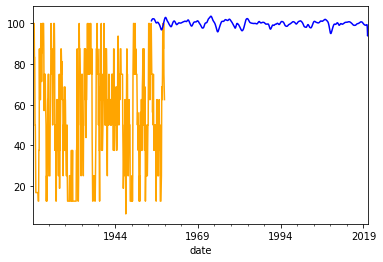

In [109]:
df.NBM16078USM509S.dropna().plot(color='orange')
df.CLI_USA.dropna().plot(color='blue')

In [110]:
minmax_scaler = MinMaxScaler()
df['CLI_USA_rescaled_recent'] = minmax_scaler.fit_transform(df.CLI_USA.values[:,np.newaxis])*(df.CLI_USA.max() - df.CLI_USA.min()) 
df['CLI_USA_rescaled_older'] = minmax_scaler.fit_transform(df.NBM16078USM509S.values[:,np.newaxis])*(df.CLI_USA.max() - df.CLI_USA.min())

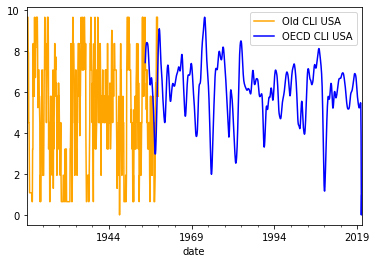

In [111]:
ax1 = df.CLI_USA_rescaled_older.dropna().plot(color='orange', label='Old CLI USA')
ax2 = df.CLI_USA_rescaled_recent.dropna().plot(color='blue', label='OECD CLI USA')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.show()

#### OECD CLI looks lagging.
- By how many months?

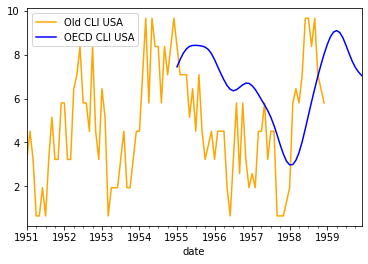

In [112]:
ax1 = df.CLI_USA_rescaled_older.loc[np.logical_and(df.index.year>1950, df.index.year<1960)].plot(color='orange', label='Old CLI USA')
ax2 = df.CLI_USA_rescaled_recent.loc[np.logical_and(df.index.year>1950, df.index.year<1960)].plot(color='blue', label='OECD CLI USA')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.show()

In [113]:
df_lag_comp = pd.merge(df.CLI_USA_rescaled_older.loc[np.logical_and(df.index.year>1950, df.index.year<1960)], df.CLI_USA_rescaled_recent.loc[np.logical_and(df.index.year>1950, df.index.year<1960)], how='inner', left_index=True, right_index=True).dropna()

In [114]:
import seaborn as sns

In [115]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 

    Shifted data filled with NaNs 

    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length


    Returns
    -------
    crosscorr : float

    """

    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else:
        return datax.corr(datay.shift(lag))

In [116]:
df_lag_comp = df_lag_comp.reset_index(drop=True)

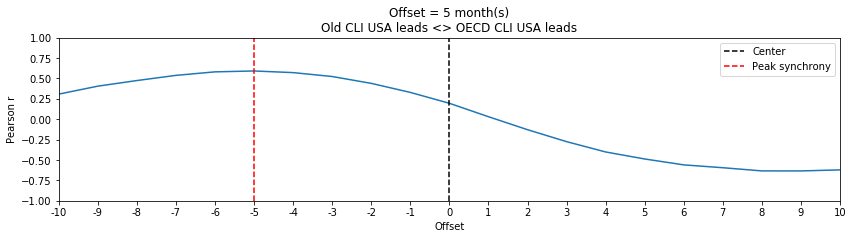

In [117]:
d1 = df_lag_comp['CLI_USA_rescaled_older']
d2 = df_lag_comp['CLI_USA_rescaled_recent']
lag_size=10
rs = [crosscorr(d1, d2, lag) for lag in range(-lag_size, lag_size+1)]
offset = int(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(int(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} month(s)\nOld CLI USA leads <> OECD CLI USA leads',ylim=[-1,1],xlim=[0,lag_size*2], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(range(0,lag_size*2+1))
ax.set_xticklabels(range(-lag_size,lag_size+1));
plt.legend()

As can be seen above, the old `CLI_USA` indicator leads the OECD CLI USA by **five months**.

### Second try: ISM Manufacturing PMI 

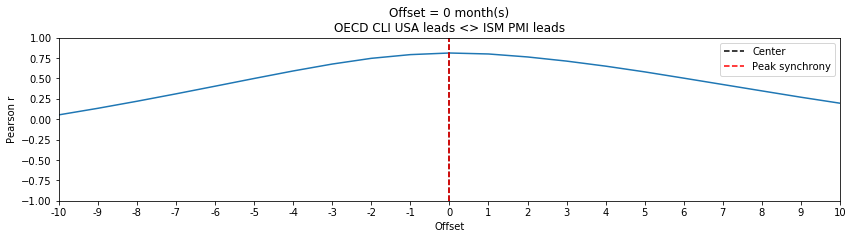

In [118]:
d1 = df.CLI_USA.loc[df.index.year>1957]
d2 = df.ISM_PMI.loc[df.index.year>1957]
lag_size=10
rs = [crosscorr(d1, d2, lag) for lag in range(-lag_size, lag_size+1)]
offset = int(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(int(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} month(s)\nOECD CLI USA leads <> ISM PMI leads',ylim=[-1,1],xlim=[0,lag_size*2], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(range(0,lag_size*2+1))
ax.set_xticklabels(range(-lag_size,lag_size+1));
plt.legend()

In [119]:
df['ISM_PMI_rescaled_recent'] = minmax_scaler.fit_transform(df.ISM_PMI.values[:,np.newaxis])*(df.ISM_PMI.max() - df.ISM_PMI.min()) 
df['CLI_USA_rescaled_older'] = minmax_scaler.fit_transform(df.NBM16078USM509S.values[:,np.newaxis])*(df.ISM_PMI.max() - df.ISM_PMI.min())
df['CLI_USA_rescaled_recent'] = minmax_scaler.fit_transform(df.CLI_USA_rescaled_recent.values[:,np.newaxis])*(df.ISM_PMI.max() - df.ISM_PMI.min()) 

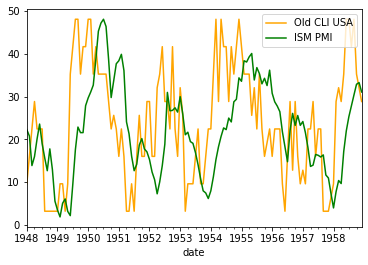

In [120]:
ax1 = df.CLI_USA_rescaled_older.loc[np.logical_and(df.index.year>=1948, df.index.year<=1958)].plot(color='orange', label='Old CLI USA')
ax2 = df.ISM_PMI_rescaled_recent.loc[np.logical_and(df.index.year>=1948, df.index.year<=1958)].plot(color='green', label='ISM PMI')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.show()

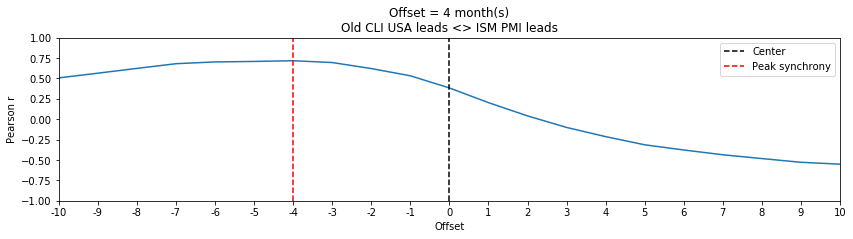

In [121]:
d1 = df.CLI_USA_rescaled_older.loc[np.logical_and(df.index.year>=1948, df.index.year<=1958)]
d2 = df.ISM_PMI_rescaled_recent.loc[np.logical_and(df.index.year>=1948, df.index.year<=1958)]
lag_size=10
rs = [crosscorr(d1, d2, lag) for lag in range(-lag_size, lag_size+1)]
offset = int(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(int(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} month(s)\nOld CLI USA leads <> ISM PMI leads',ylim=[-1,1],xlim=[0,lag_size*2], xlabel='Offset',ylabel='Pearson r')
ax.set_xticks(range(0,lag_size*2+1))
ax.set_xticklabels(range(-lag_size,lag_size+1));
plt.legend()

In [122]:
d1 = df.CLI_USA_rescaled_older.loc[np.logical_and(df.index.year>=1947, df.index.year<=1958)]
d1_rolling = [d1.rolling(window=i).mean()[12:].values for i in range(1, 14)]
d1_dict = {'r'+str(i):old_cli_usa for i, old_cli_usa in enumerate(d1_rolling)}
d1_rolling = pd.DataFrame(index=d1.loc[d1.index.year>=1948].index, data=d1_dict)

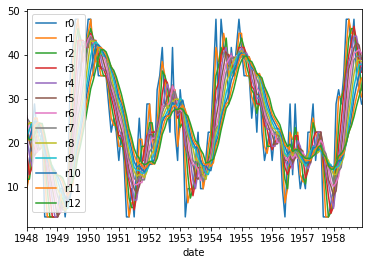

In [123]:
d1_rolling.plot()

In [124]:
rwtl_corsscorr = np.array([[crosscorr(d1_rolling[key], d2, lag) for lag in range(-lag_size, lag_size+1)] for key in d1_rolling.keys()])

In [125]:
rwtl_corsscorr = pd.DataFrame(rwtl_corsscorr)
rwtl_corsscorr.columns = list(range(-lag_size, lag_size+1))

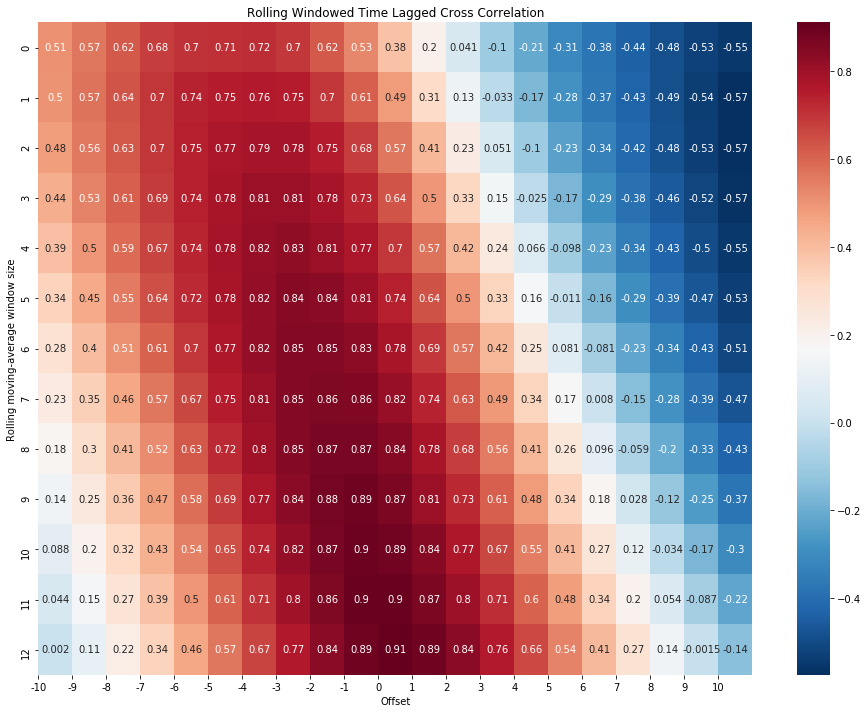

In [126]:
f,ax = plt.subplots(figsize=(16,12))
sns.heatmap(rwtl_corsscorr,cmap='RdBu_r',ax=ax, annot=True)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,21], xlabel='Offset',ylabel='Rolling moving-average window size')
ax.set_xticks(range(0,lag_size*2+1))
ax.set_xticklabels(range(-lag_size, lag_size+1));

#### Conclusion: 12-month moving averages of **Old CLI USA** without adjusting any lag, i.e., *no offst* shows the highest correlation coefficient.

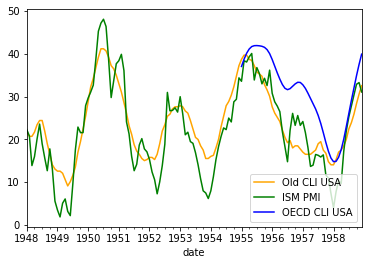

In [127]:
ax1 = d1_rolling['r12'].loc[np.logical_and(d1_rolling.index.year>=1948, d1_rolling.index.year<=1958)].plot(color='orange', label='Old CLI USA')
ax2 = d2.loc[np.logical_and(d2.index.year>=1948, d2.index.year<=1958)].plot(color='green', label='ISM PMI')
ax3 = df.CLI_USA_rescaled_recent.loc[np.logical_and(df.index.year>=1948, df.index.year<=1958)].plot(color='blue', label='OECD CLI USA')
ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')
plt.show()

In [128]:
df['OLD_CLI_USA'] = df.NBM16078USM509S.rolling(window=12).mean()

In [129]:
df.drop(columns=['CLI_USA_rescaled_recent', 'CLI_USA_rescaled_older'], inplace=True)

In [130]:
minmax_scaler = MinMaxScaler()
df['CLI_USA_rescaled_recent'] = minmax_scaler.fit_transform(df.CLI_USA.values[:,np.newaxis])*(df.CLI_USA.max() - df.CLI_USA.min()) 
df['CLI_USA_rescaled_older'] = minmax_scaler.fit_transform(df.OLD_CLI_USA.values[:,np.newaxis])*(df.CLI_USA.max() - df.CLI_USA.min())

#### Now we have the equally-scaled continuous CLI  USA from 1919 to present.

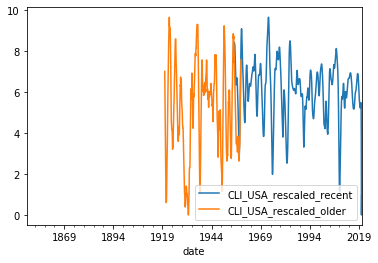

In [131]:
df[['CLI_USA_rescaled_recent', 'CLI_USA_rescaled_older']].plot()

#### Finally, we have `GRTH` as follows:

In [132]:
shift_n = 1
diff_recent = df.CLI_USA_rescaled_recent - df.CLI_USA_rescaled_recent.shift(shift_n)
diff_older = df.CLI_USA_rescaled_older - df.CLI_USA_rescaled_older.shift(shift_n)
mf['GRTH'] = diff_recent.loc[diff_recent.index.year>=1957]
mf['GRTH'] = mf.GRTH.fillna(diff_older)

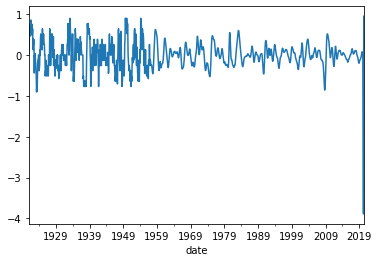

In [133]:
mf.GRTH.plot()

## 2) Inflation

`INFL` (Inflation): A first difference of percentage change in Consumer Price Index YoY
- 1949 to present, **USCPI**: US CPI Urban Consumers YoY NSA at month $t$ - the same at month $t-1$
- Before that date, **CPUSAM_YOY**: This is the underlying index of **USCPI**. So we calculate YoY changes in a percentage term year over year, **CPUSAM_YOY**, and then take first differences.

In [134]:
df['CPUSAM_YOY'] = np.round((df.CPUSAM/df.CPUSAM.shift(12)-1)*100, decimals=1)

In [135]:
(df.CPUSAM_YOY - df.USCPI).describe()

count    870.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
dtype: float64

In [136]:
shift_n = 1
infl_recent = df.USCPI - df.USCPI.shift(shift_n)
infl_older = df.CPUSAM_YOY - df.CPUSAM_YOY.shift(shift_n)

In [137]:
mf['INFL'] = infl_recent.fillna(infl_older)

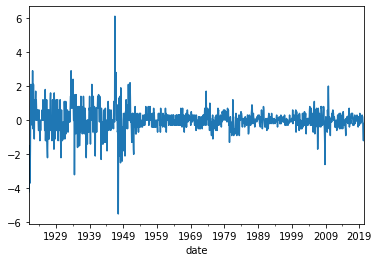

In [138]:
mf.INFL.plot()

## 3) Uncertainty

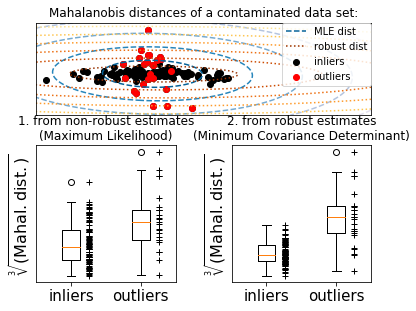

In [140]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.covariance import EmpiricalCovariance, MinCovDet

n_samples = 125
n_outliers = 25
n_features = 2

# generate data
gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)
# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), np.arange(1, n_features)] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

# fit a Minimum Covariance Determinant (MCD) robust estimator to data
robust_cov = MinCovDet().fit(X)

# compare estimators learnt from the full data set with true parameters
emp_cov = EmpiricalCovariance().fit(X)

# #############################################################################
# Display results
fig = plt.figure()
plt.subplots_adjust(hspace=-.1, wspace=.4, top=.95, bottom=.05)

# Show data set
subfig1 = plt.subplot(3, 1, 1)
inlier_plot = subfig1.scatter(X[:, 0], X[:, 1],
                              color='black', label='inliers')
outlier_plot = subfig1.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:],
                               color='red', label='outliers')
subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title("Mahalanobis distances of a contaminated data set:")

# Show contours of the distance functions
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]

mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = subfig1.contour(xx, yy, np.sqrt(mahal_emp_cov),
                                  cmap=plt.cm.PuBu_r,
                                  linestyles='dashed')

mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = subfig1.contour(xx, yy, np.sqrt(mahal_robust_cov),
                                 cmap=plt.cm.YlOrBr_r, linestyles='dotted')

subfig1.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
                inlier_plot, outlier_plot],
               ['MLE dist', 'robust dist', 'inliers', 'outliers'],
               loc="upper right", borderaxespad=0)
plt.xticks(())
plt.yticks(())

# Plot the scores for each point
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
subfig2 = plt.subplot(2, 2, 3)
subfig2.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
subfig2.plot(np.full(n_samples - n_outliers, 1.26),
             emp_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig2.plot(np.full(n_outliers, 2.26),
             emp_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig2.set_title("1. from non-robust estimates\n(Maximum Likelihood)")
plt.yticks(())

robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
subfig3 = plt.subplot(2, 2, 4)
subfig3.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]],
                widths=.25)
subfig3.plot(np.full(n_samples - n_outliers, 1.26),
             robust_mahal[:-n_outliers], '+k', markeredgewidth=1)
subfig3.plot(np.full(n_outliers, 2.26),
             robust_mahal[-n_outliers:], '+k', markeredgewidth=1)
subfig3.axes.set_xticklabels(('inliers', 'outliers'), size=15)
subfig3.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
subfig3.set_title("2. from robust estimates\n(Minimum Covariance Determinant)")
plt.yticks(())

plt.show()

# 4. Save

In [141]:
dataset_filename = '../../data/processed/macro_factors'
mf.to_csv(dataset_filename + '.log')
mf.to_pickle(dataset_filename + '.pkl')

In [142]:
df.CPUSAM_YOY.loc[np.logical_and(df.index.year>=1945, df.index.year<=1946)]

date
1945-01     2.3
1945-02     2.3
1945-03     2.3
1945-04     1.7
1945-05     2.3
1945-06     2.8
1945-07     2.3
1945-08     2.3
1945-09     2.3
1945-10     2.3
1945-11     2.3
1945-12     2.2
1946-01     2.2
1946-02     1.7
1946-03     2.8
1946-04     3.4
1946-05     3.4
1946-06     3.3
1946-07     9.4
1946-08    11.6
1946-09    12.7
1946-10    14.9
1946-11    17.7
1946-12    18.1
Freq: M, Name: CPUSAM_YOY, dtype: float64

In [143]:
mf.INFL.loc[np.logical_and(bf.index.year>=1945, bf.index.year<=1946)]

date
1945-01    0.0
1945-02    0.0
1945-03    0.0
1945-04   -0.6
1945-05    0.6
1945-06    0.5
1945-07   -0.5
1945-08    0.0
1945-09    0.0
1945-10    0.0
1945-11    0.0
1945-12   -0.1
1946-01    0.0
1946-02   -0.5
1946-03    1.1
1946-04    0.6
1946-05    0.0
1946-06   -0.1
1946-07    6.1
1946-08    2.2
1946-09    1.1
1946-10    2.2
1946-11    2.8
1946-12    0.4
Freq: M, Name: INFL, dtype: float64